In [1]:
import librosa
import scipy
import os
import numpy as np
from tqdm.notebook import tqdm
import soundfile
from IPython.display import Audio
import matplotlib.pyplot as plt

In [10]:
data_dir = "./vlsp2020_train_set_02/"

In [11]:
with open("filtered_files.txt", 'r') as f:
    filelist = f.readlines()

In [12]:
for i, line in enumerate(filelist):
    filelist[i] = line.strip()

In [13]:
filelist[:3]

['speaker_009-000005-1.wav',
 'speaker_009-004101-1.wav',
 'speaker_009-005125-1.wav']

#### Remove too low audio

In [14]:
sample = filelist[0]
au, sr = librosa.load(os.path.join(data_dir, sample))

In [15]:
Audio(data=au, rate=sr)

In [16]:
au

array([ 2.3334613e-03,  1.7057444e-03, -1.9186675e-05, ...,
       -3.8181207e-04, -3.0726762e-04,  0.0000000e+00], dtype=float32)

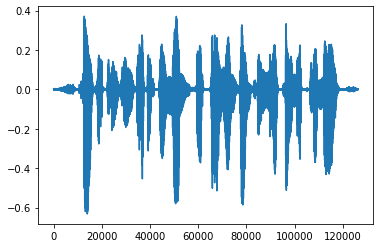

In [17]:
plt.plot(au)

In [59]:
def mean_amplitude(path):
    au, _ = librosa.load(os.path.join(data_dir, path))
#     db = librosa.amplitude_to_db(au)
    return np.mean(np.abs(au))

In [60]:
db_list = []
for file in tqdm(filelist):
    db_list.append(mean_amplitude(file))
db_list = np.array(db_list)

  0%|          | 0/13861 [00:00<?, ?it/s]

In [61]:
np.min(db_list)

0.0013635969

In [62]:
np.max(db_list)

0.19514896

In [63]:
m = np.mean(db_list)
m

0.060321234

In [83]:
np.count_nonzero(db_list < 0.002)

8

In [84]:
low_files = []
for i, val in enumerate(db_list < 0.002):
    if val:
        low_files.append(filelist[i])

In [97]:
low_files = []
for file in filelist:
    if "speaker_573" in file:
        low_files.append(file)

In [98]:
low_files

['speaker_573-012639-1.wav',
 'speaker_573-031327-1.wav',
 'speaker_573-031583-1.wav',
 'speaker_573-031839-1.wav',
 'speaker_573-038495-1.wav',
 'speaker_573-039775-1.wav',
 'speaker_573-044895-1.wav',
 'speaker_573-045663-1.wav',
 'speaker_573-046943-1.wav',
 'speaker_573-076639-1.wav',
 'speaker_573-080223-1.wav',
 'speaker_573-086367-1.wav',
 'speaker_573-095071-1.wav',
 'speaker_573-098911-1.wav']

In [103]:
sample = low_files[3]
au, sr = librosa.load(os.path.join(data_dir, sample))

In [104]:
Audio(data=au, rate=sr)

In [96]:
sample

'speaker_573-031583-1.wav'

In [105]:
duration = np.zeros(len(filelist))
for i, file in tqdm(enumerate(filelist)):
    duration[i] = librosa.get_duration(filename=os.path.join(data_dir, file))

0it [00:00, ?it/s]

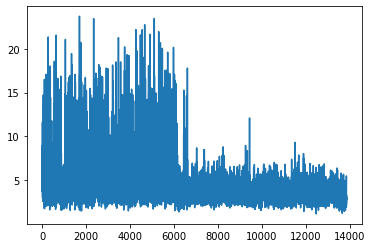

In [106]:
plt.plot(duration)

In [107]:
np.min(duration)

1.1377777777777778

## Noise filtering

In [113]:
noise = []
for file in tqdm(filtered_files):
    au, sr = librosa.load(os.path.join(data_dir, file))
    noise.append(np.max(librosa.feature.spectral_flatness(y=au)))

  0%|          | 0/13655 [00:00<?, ?it/s]

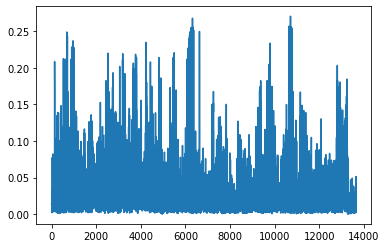

In [114]:
plt.plot(noise)

In [115]:
noise = np.array(noise)

In [116]:
np.min(noise)

0.000260815

In [117]:
np.max(noise)

0.2707609

In [118]:
np.mean(noise)

0.03185426

In [160]:
np.count_nonzero(noise > 0.02)

6574

In [167]:
noise_files = []
for i, val in enumerate(noise > 0.02):
    if val:
        noise_files.append(filtered_files[i])

In [168]:
noise_files[:10]

['speaker_009-007429-1.wav',
 'speaker_009-042500-1.wav',
 'speaker_009-111108-1.wav',
 'speaker_009-111620-1.wav',
 'speaker_009-112644-1.wav',
 'speaker_011-032565-1.wav',
 'speaker_011-066566-1.wav',
 'speaker_011-086581-1.wav',
 'speaker_011-119045-1.wav',
 'speaker_012-000704-1.wav']

In [169]:
sample = noise_files[1]
au, sr = librosa.load(os.path.join(data_dir, sample))
Audio(data=au, rate=sr)

## Save files

In [170]:
# filter too long (> 25) and too short (< 2) audio
cleaned_files = []
for file in filtered_files:
    if file in low_files or file in noise_files:
        continue
    cleaned_files.append(file)

In [171]:
len(cleaned_files)

7081

In [176]:
sample = cleaned_files[1234]
au, sr = librosa.load(os.path.join(data_dir, sample))
Audio(data=au, rate=sr)

In [177]:
with open("cleaned_files.txt", "w") as f:
    for line in cleaned_files:
        f.write(line + "\n")

## Clustering

In [179]:
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path

In [180]:
encoder = VoiceEncoder()

Loaded the voice encoder model on cpu in 0.02 seconds.


In [181]:
def get_au_feat(path):
    fpath = Path(path)
    wav = preprocess_wav(fpath)
    return encoder.embed_utterance(wav)

In [182]:
feat_data = np.zeros((len(cleaned_files), 256))
for i, file in tqdm(enumerate(cleaned_files)):
    feat_data[i] = get_au_feat(os.path.join(data_dir, file))

0it [00:00, ?it/s]

In [183]:
with open("cleaned_feat_data.npy", "wb") as f:
    np.save(f, feat_data)

In [189]:
# find number of clusters
spk_dict = {}
feat_dict = {}
for i, file in enumerate(cleaned_files):
    idx = int(file.split("-")[0].split("_")[1])
    if idx not in spk_dict:
        spk_dict[idx] = []
        feat_dict[idx] = []
    spk_dict[idx].append(file)
    feat_dict[idx].append(feat_data[i])

In [192]:
for idx in feat_dict:
    feat_dict[idx] = np.array(feat_dict[idx])

In [187]:
from sklearn.cluster import KMeans

In [195]:
current = 100
label_dict = {}
for idx in spk_dict: 
    data = feat_dict[idx]
    if len(data) > 5:
        kmean = KMeans(n_clusters=3).fit(data) 
        label_dict[idx] = kmean.predict(data) + current
        current += 3
    else:
        label_dict[idx] = np.ones(len(data)) + current
        current += 1

In [206]:
data_df = []
for idx in label_dict:
    for label, file in zip(label_dict[idx], spk_dict[idx]):
        data_df.append([file, int(label)])

In [207]:
import pandas as pd

In [208]:
df = pd.DataFrame(data_df, columns=["filename", "spkr_id"])

In [210]:
df

,filename,spkr_id
0,speaker_009-000005-1.wav,101
1,speaker_009-004101-1.wav,101
2,speaker_009-005125-1.wav,101
3,speaker_009-007685-1.wav,102
4,speaker_009-011525-1.wav,101
...,...,...
7076,speaker_953_469563-1.wav,1589
7077,speaker_953_469575-1.wav,1590
7078,speaker_953_469583-1.wav,1588
7079,speaker_953_470043-1.wav,1590


In [211]:
df.to_csv("./cleaned_file_id.csv", index=False)

## Combine files

In [212]:
p_df = pd.read_csv("./vlsp_full_filelist.csv", delimiter="|")

In [214]:
p_df.columns = ["filename", "spkr_id", "pn"]

In [215]:
p_df

,filename,spkr_id,pn
0,dataset/vlsp_wav/speaker_009-004101-1.wav,1022,t̪ˈiɛɜp tˈɛʊ ʂˈu2ŋ tʃˈiɲ fˈaːɪɜ ɗˈaːɪ6 hˈɔ6kh ...
1,dataset/vlsp_wav/speaker_009-005125-1.wav,614,t̪wˈiəɜn ʂˈo tʃˈen ɗˈiə6 bˈaː2n t̪ˈi4ɲ wˈaː4ŋ ...
2,dataset/vlsp_wav/speaker_009-007429-1.wav,1022,tɕˈi4 ɡˈɔɜ t̪ˈaːŋ ɗˈo2 tˈɛʊ hˈaː6ŋ vˈu5 lˌaː2 ...
3,dataset/vlsp_wav/speaker_009-007685-1.wav,946,ʂˈaʊ ɗˈɔɜ tɕˈu4 ɲˈaː2 mˈəːɪ2 xˈaːɜc ˈuəɜŋ tʃˈa...
4,dataset/vlsp_wav/speaker_009-011525-1.wav,614,ɡˈuəɜj ɡˈu2ŋ ɲˈaː2 ɗˈyə2ŋ hˈoə2n t̪ˈoə2n mˈəɜt...
...,...,...,...
13566,dataset/vlsp_wav/speaker_953_469575-1.wav,662,t̪ˈoɪ mˈaɪ mˈaɜn xˌi ʂˈəː4 hˈy5w ɲˌy5ŋ bˈaː6n ...
13567,dataset/vlsp_wav/speaker_953_469583-1.wav,193,ɗˈaː4m bˈaːʊ4 ˈaːn nˈiɲ tʃˈə6t̪ t̪ˈy6 tʃˈɔ vˌa...
13568,dataset/vlsp_wav/speaker_953_470043-1.wav,662,xˌo ɡˈɔɜ ɲˈiʊ2 ŋˈyə2j tʃˈen tˈeɜ zˈəːɪɜ lˈaː2m...
13569,dataset/vlsp_wav/speaker_953_470051-1.wav,662,fˈyəŋ hˈyəɜŋ ɲˈiɛ6m vˈu6 zˈaːɪ4 fˈaːɜp tɕˈu4 ˈ...


't̪ˈiɛɜp tˈɛʊ ʂˈu2ŋ tʃˈiɲ fˈaːɪɜ ɗˈaːɪ6 hˈɔ6kh ʂˈi5 bˈiɲ bˈo6 tˈyə6ŋ tˈy zˈyəŋ t̪ˈy6 sˈyəŋ lˈaː2m ɗˈoɜkh ʂˈy t̪ˈo4 ɗˈoɜkh nˈaɜm wˈiə2n tɕˈi4 hwˈi vˈiɛ6kh t̪ˈiʊ5 tʃˈy2 ŋˈiə5 wˈən'

In [223]:
new_data = []
for file, label in data_df:
    d = p_df[p_df["filename"].str.contains(file)]
    if len(d) > 0:
        new_data.append([file, label, d.iloc[0].pn])

In [224]:
df = pd.DataFrame(new_data, columns=["filename", "spkr_id", "phonemes"])

In [228]:
df["filename"] = "dataset/vlsp_wav/" + df["filename"]

In [229]:
df

,filename,spkr_id,phonemes
0,dataset/vlsp_wav/speaker_009-004101-1.wav,101,t̪ˈiɛɜp tˈɛʊ ʂˈu2ŋ tʃˈiɲ fˈaːɪɜ ɗˈaːɪ6 hˈɔ6kh ...
1,dataset/vlsp_wav/speaker_009-005125-1.wav,101,t̪wˈiəɜn ʂˈo tʃˈen ɗˈiə6 bˈaː2n t̪ˈi4ɲ wˈaː4ŋ ...
2,dataset/vlsp_wav/speaker_009-007685-1.wav,102,ʂˈaʊ ɗˈɔɜ tɕˈu4 ɲˈaː2 mˈəːɪ2 xˈaːɜc ˈuəɜŋ tʃˈa...
3,dataset/vlsp_wav/speaker_009-011525-1.wav,101,ɡˈuəɜj ɡˈu2ŋ ɲˈaː2 ɗˈyə2ŋ hˈoə2n t̪ˈoə2n mˈəɜt...
4,dataset/vlsp_wav/speaker_009-054532-1.wav,100,hˈɔ2n ɗˈaːʊ4 tɕˈiɜɲ nˈa2m ɡˈaːɜc bˈəː2 bˈiɛ4n ...
...,...,...,...
6969,dataset/vlsp_wav/speaker_953_469563-1.wav,1589,t̪ˈo4 zˈaːɜ tʃˈi6 ɗˈəʊ2 t̪ˈy tʃˈen ʂˈaʊɜ mˈyəj...
6970,dataset/vlsp_wav/speaker_953_469575-1.wav,1590,t̪ˈoɪ mˈaɪ mˈaɜn xˌi ʂˈəː4 hˈy5w ɲˌy5ŋ bˈaː6n ...
6971,dataset/vlsp_wav/speaker_953_469583-1.wav,1588,ɗˈaː4m bˈaːʊ4 ˈaːn nˈiɲ tʃˈə6t̪ t̪ˈy6 tʃˈɔ vˌa...
6972,dataset/vlsp_wav/speaker_953_470043-1.wav,1590,xˌo ɡˈɔɜ ɲˈiʊ2 ŋˈyə2j tʃˈen tˈeɜ zˈəːɪɜ lˈaː2m...


In [230]:
df.to_csv("./vlsp_full_filelist_new.csv", index=False, sep='|')